<a href="https://colab.research.google.com/github/prog815/portfOptim/blob/master/%D0%9F%D0%BE%D0%B8%D1%81%D0%BA_%D0%BB%D1%83%D1%87%D1%88%D0%B8%D1%85_%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%BE%D0%B2_%D0%B4%D0%BB%D1%8F_%D0%BF%D0%BE%D1%80%D1%82%D1%84%D0%B5%D0%BB%D1%8F_%D0%B3%D0%B5%D0%BD%D0%B5%D1%82%D0%B8%D0%BA%D0%BE%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Поиск лучших параметров для портфеля генетикой

Проект "Оптимизация инвестиционного портфеля".

https://github.com/prog815/portfOptim

Енин А.В.

Оренбург - 2020

17.09.2020

Оптимизируем параметры портфеля (глубина обучения и глубина теста) для получения максимального коэффициента Шарпа. Оптимизируем генетикой.

# Подгружаем библиотеки

In [1]:
!pip install bt

     |████████████████████████████████| 2.7MB 2.6MB/s 
  Created wheel for bt: filename=bt-0.2.7-cp36-cp36m-linux_x86_64.whl size=533275 sha256=89c43091a78835f973fa691e908d6c6dbc00af421efca3214e7ff3ac7f7ea1f6
  Stored in directory: /root/.cache/pip/wheels/ae/8a/a2/a679757e4e7219e6f17727d1422d4ce32da847678c6559da35
  Created wheel for ffn: filename=ffn-0.3.4-cp36-none-any.whl size=22813 sha256=d37d771533110dc4941a31f015badb4840eda0a5c91672a4a1e3a2f07a3a0ecb
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
Successfully built bt ffn


In [2]:
import bt
import pandas as pd
import seaborn
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)
/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
%matplotlib inline

# Подгружаем историю котировок

In [4]:
# fetch some data
data = bt.get(['AAPL','GE','BAC','AMD','PLUG','F'], start='2010-01-01')
print( data.head())

                aapl         ge        bac   amd  plug         f
Date                                                            
2010-01-04  6.604801  10.733057  13.816905  9.70   7.0  7.238358
2010-01-05  6.616219  10.788632  14.266021  9.71   7.0  7.717158
2010-01-06  6.510980  10.733057  14.433337  9.57   6.7  8.005848
2010-01-07  6.498945  11.288810  14.908874  9.47   6.7  8.210042
2010-01-08  6.542150  11.531955  14.776777  9.43   6.8  8.231167


# Равновесная стратегия

## Считаем

In [5]:
s0 = bt.Strategy('равномерный', [bt.algos.RunMonthly(),
                                 bt.algos.SelectAll(),
                                 bt.algos.WeighEqually(),
                                 bt.algos.Rebalance()])
test0 = bt.Backtest(s0, data)
res0 = bt.run(test0)



равномерный
0% [############################# ] 100% | ETA: 00:00:00

## График истории баланса

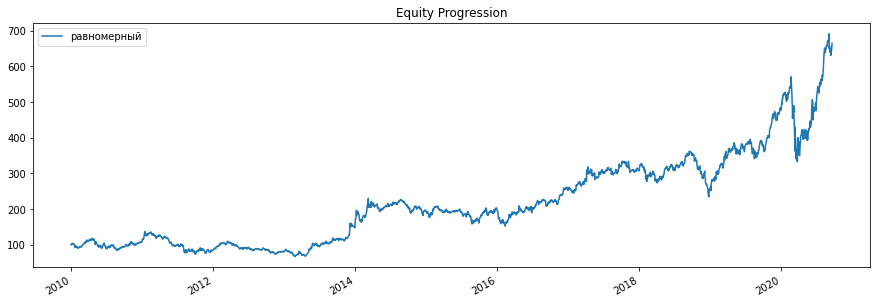

In [6]:
res0.plot()

## График истории долей портфеля

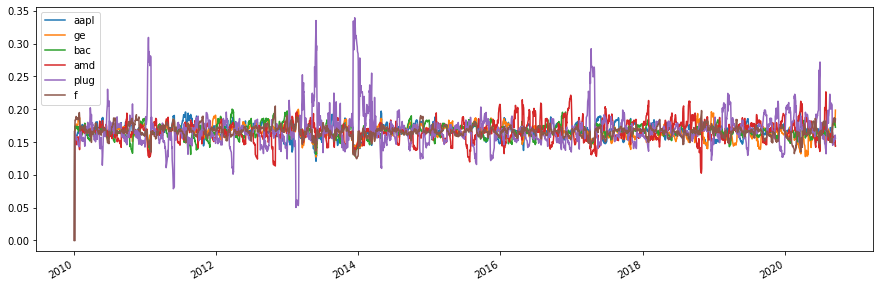

In [7]:
res0.plot_security_weights()

## Итоги по всему портфелю

In [8]:
res0.display()

Stat                 равномерный
-------------------  -------------
Start                2010-01-03
End                  2020-09-17
Risk-free rate       0.00%

Total Return         564.80%
Daily Sharpe         0.73
Daily Sortino        1.22
CAGR                 19.36%
Max Drawdown         -50.58%
Calmar Ratio         0.38

MTD                  -1.46%
3m                   40.26%
6m                   81.09%
YTD                  38.12%
1Y                   70.65%
3Y (ann.)            27.97%
5Y (ann.)            31.15%
10Y (ann.)           21.94%
Since Incep. (ann.)  19.36%

Daily Sharpe         0.73
Daily Sortino        1.22
Daily Mean (ann.)    22.37%
Daily Vol (ann.)     30.53%
Daily Skew           0.10
Daily Kurt           7.06
Best Day             14.06%
Worst Day            -13.99%

Monthly Sharpe       0.78
Monthly Sortino      1.65
Monthly Mean (ann.)  22.73%
Monthly Vol (ann.)   29.30%
Monthly Skew         0.51
Monthly Kurt         1.22
Best Month           35.84%
Worst Month     

# Поиск лучших параметров в оптимизации

## Подгружаем библиотеку генетической оптимизации

In [9]:
! pip install git+https://github.com/prog815/progGA

  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-p6tkkoko
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-p6tkkoko
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3627 sha256=4f0141c3b98b6123959780539f4112a9d1a60f545e420b2fe276c3986161ded3
  Stored in directory: /tmp/pip-ephem-wheel-cache-m2wfxfme/wheels/9c/7a/cc/d1ffa9ccaa42befda21d63d0e01c942a0add5854c37e0bd2ff
Successfully built progGA


In [10]:
from progGA import ListGenetic

## Определяем функцию качества (коэффициент шарпа)

In [12]:
qualityCache = {}

In [22]:
def getQualityMethod(lookback,testlen):
    try:
        return qualityCache[(lookback,testlen)]
    except Exception :
        pass    

    s = bt.Strategy('s', [bt.algos.RunEveryNPeriods(testlen,offset=lookback),
                          bt.algos.SelectAll(),
                          bt.algos.WeighMeanVar(lookback=pd.DateOffset(days=lookback)),
                          bt.algos.Rebalance()])
    test = bt.Backtest(s, data, progress_bar=False)
    res = bt.run(test)
    q = res[0].daily_sharpe
    qualityCache[(lookback,testlen)] = q

    return q

## Создаем модель оптимизации

In [38]:
modelGA = ListGenetic(pop_size=20,
                      lookback=range(50,400),
                      testlen=range(1,300),
                      quality_method=getQualityMethod)

## Ищем лучшие парметры оптимизируя в генетике

In [39]:
modelGA.fit(1000)

1 {'quality': 1.0551899542272232, 'lookback': 141, 'testlen': 257}
2 {'quality': 1.0980832929352962, 'lookback': 165, 'testlen': 180}
3 {'quality': 1.2070535054553764, 'lookback': 192, 'testlen': 29}
4 {'quality': 1.0487803045188708, 'lookback': 166, 'testlen': 258}
5 {'quality': 1.1485821027180239, 'lookback': 165, 'testlen': 25}
6 {'quality': 0.8699998724029017, 'lookback': 218, 'testlen': 179}
7 {'quality': 1.084845500433877, 'lookback': 163, 'testlen': 25}
8 {'quality': 1.0576079495757722, 'lookback': 195, 'testlen': 255}
9 {'quality': 0.9495269650745928, 'lookback': 166, 'testlen': 182}
10 {'quality': 1.1675018683925331, 'lookback': 192, 'testlen': 26}
11 {'quality': 1.0391082418087176, 'lookback': 220, 'testlen': 31}
12 {'quality': 0.9846365808344577, 'lookback': 194, 'testlen': 257}
13 {'quality': 1.0705518550834952, 'lookback': 143, 'testlen': 262}
14 {'quality': 0.9891081224435481, 'lookback': 162, 'testlen': 256}


/usr/local/lib/python3.6/dist-packages/ffn/core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


15 {'quality': 1.2697331876403661, 'lookback': 166, 'testlen': 18}
16 {'quality': 1.1793574883826685, 'lookback': 146, 'testlen': 23}
17 {'quality': 1.03761629155479, 'lookback': 145, 'testlen': 260}
18 {'quality': 1.0601921261603235, 'lookback': 193, 'testlen': 256}
19 {'quality': 1.0413698394046351, 'lookback': 167, 'testlen': 263}
20 {'quality': 1.2549612372748908, 'lookback': 163, 'testlen': 22}
21 {'quality': 1.0700082374881723, 'lookback': 149, 'testlen': 21}
22 {'quality': 1.2305546011887976, 'lookback': 188, 'testlen': 35}
23 {'quality': 1.2223672130062564, 'lookback': 190, 'testlen': 28}
24 {'quality': 1.20569870869897, 'lookback': 168, 'testlen': 19}
25 {'quality': 1.1485821027180239, 'lookback': 165, 'testlen': 25}
26 {'quality': 1.2091807236381344, 'lookback': 161, 'testlen': 22}
27 {'quality': 1.276844218878685, 'lookback': 167, 'testlen': 20}
28 {'quality': 1.2585083030859887, 'lookback': 167, 'testlen': 18}
29 {'quality': 1.1273922360356512, 'lookback': 171, 'testlen': 2

## Выводим графики обучения

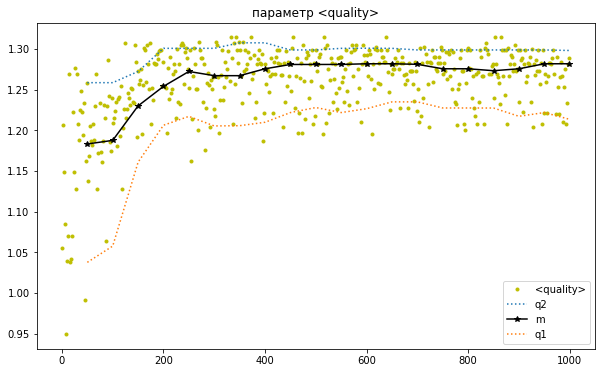

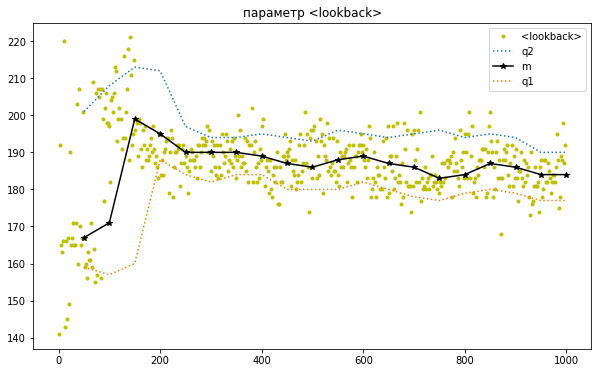

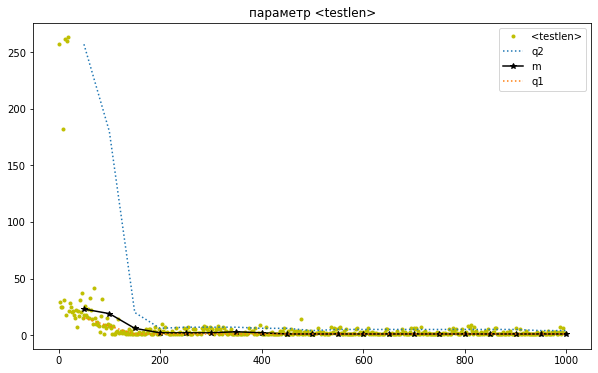

In [40]:
modelGA.plot_hist_new(('quality','lookback','testlen'))

## Лучшие найденные параметры

In [41]:
modelGA.getBestParams()

{'lookback': 187, 'testlen': 3}

# Лучшая модель

Лучшие результаты сосредоточились вокруг глубины обучения в 150 дней и глубины тестирования в 150 дней.

## Расчет

In [42]:
lookback_best = 187
testlen_best = 3

s_best = bt.Strategy('лучший', [bt.algos.RunEveryNPeriods(testlen_best,offset=lookback_best),
                                bt.algos.SelectAll(),
                                bt.algos.WeighMeanVar(lookback=pd.DateOffset(days=lookback_best)),
                                bt.algos.Rebalance()])
test_best = bt.Backtest(s_best, data)
res_best = bt.run(test_best)

лучший
0% [############################# ] 100% | ETA: 00:00:00

/usr/local/lib/python3.6/dist-packages/ffn/core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


## График истории баланса

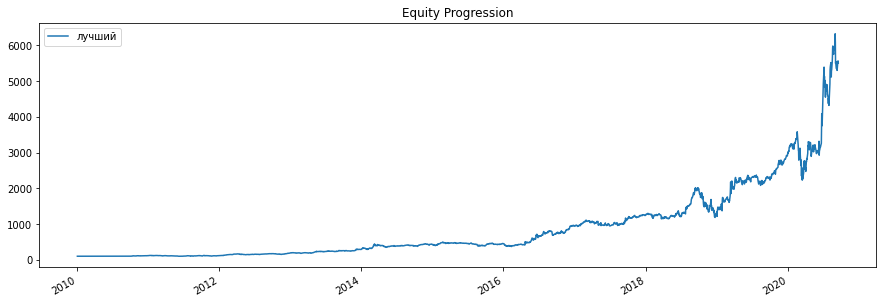

In [43]:
res_best.plot()

## График истории долей портфеля

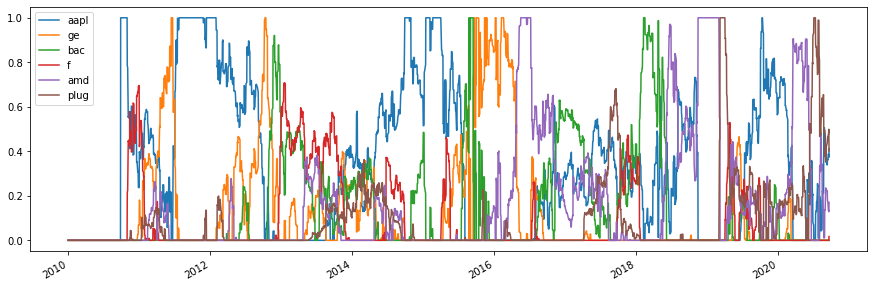

In [44]:
res_best.plot_security_weights()

## Итоги по всему портфелю

In [45]:
res_best.display()

Stat                 лучший
-------------------  ----------
Start                2010-01-03
End                  2020-09-17
Risk-free rate       0.00%

Total Return         5411.27%
Daily Sharpe         1.24
Daily Sortino        2.12
CAGR                 45.43%
Max Drawdown         -41.26%
Calmar Ratio         1.10

MTD                  -8.41%
3m                   74.98%
6m                   126.33%
YTD                  88.03%
1Y                   138.52%
3Y (ann.)            71.51%
5Y (ann.)            68.82%
10Y (ann.)           49.31%
Since Incep. (ann.)  45.43%

Daily Sharpe         1.24
Daily Sortino        2.12
Daily Mean (ann.)    43.70%
Daily Vol (ann.)     35.35%
Daily Skew           0.67
Daily Kurt           11.95
Best Day             21.08%
Worst Day            -15.06%

Monthly Sharpe       1.31
Monthly Sortino      3.85
Monthly Mean (ann.)  43.03%
Monthly Vol (ann.)   32.87%
Monthly Skew         1.42
Monthly Kurt         4.39
Best Month           46.61%
Worst Month         

# Выводы

Оптимальные значения найдены.

Тестовая длинна получилсь минимальной. Стремится к единице.

Обучающая выборка на уровне 187.

Оптимизация шла очень долго. Около 1-1,5 часов. 
Но окестность определена.